In [2]:
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

import sys
sys.path.append("../tfti")
from tfti_batched_inference import *

In [41]:
config = get_config(
    problem="genomics_binding_deepsea_gm12878",
    model="tfti_transformer",
    hparams_set="tfti_transformer_base",
    hparams="",
    checkpoint_path="~/Downloads/6-64-25/model.ckpt-210001",
)

preprocess_batch_fn = get_preprocess_batch_fn(config)
inference_fn = get_inference_fn(config)

In [12]:
problem, model, hparams = get_problem_model_hparams(config)
tmp_dir = os.path.expanduser("~/t2t_datagen")

problem.maybe_download_and_unzip(tmp_dir)
generator = problem.generator(tmp_dir, is_training=False)
examples = list(generator)  # small enough to load into memory

In [20]:
batch_size = 100

sample = np.random.choice(examples, batch_size)

example = preprocess_batch_fn(
    [x["inputs"] for x in sample],
    [x["targets"] for x in sample],
    np.zeros([batch_size, 919]).astype(bool),
)

fetch = inference_fn(example)

Populating the interactive namespace from numpy and matplotlib


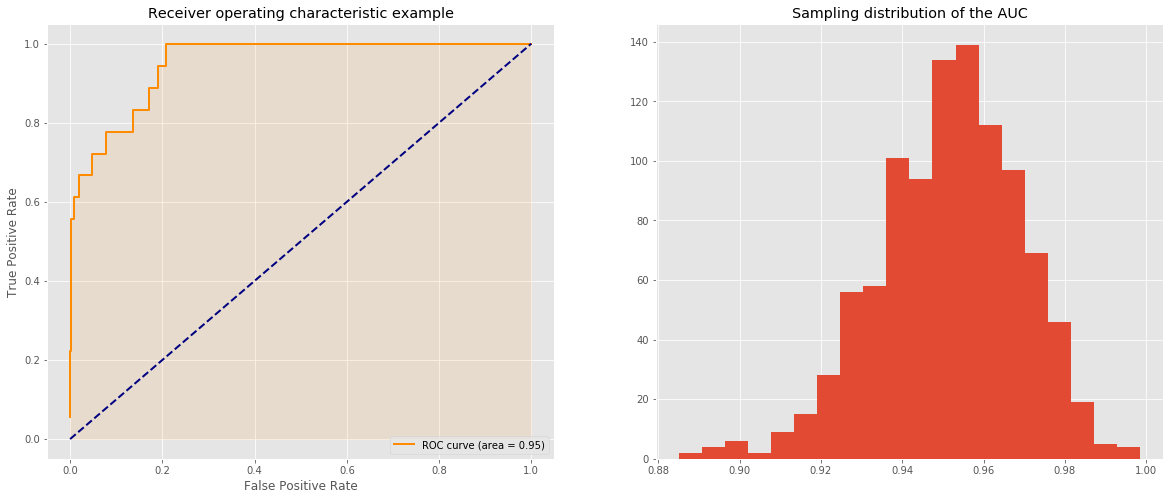

In [57]:
from sklearn.metrics import roc_curve, auc
%pylab inline
plt.style.use("ggplot")

y_true = fetch["labels"].ravel()
y_score = fetch["predictions"].ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(20., 8.))
plt.subplot(121)

lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, color='darkorange', alpha=0.1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)

def bootstrap(*args):
    n = args[0].shape[0]
    indices = np.random.choice(n, n, replace=True)
    return [x[indices] for x in args]

roc_aucs = []

for _ in range(1000):
    y_true_bs, y_score_bs = bootstrap(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true_bs, y_score_bs)
    roc_aucs.append(auc(fpr, tpr))

plt.hist(roc_aucs, bins=20)
plt.title("Sampling distribution of the AUC")
plt.show()